In [71]:
import numpy as np
import cv2
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, Lambda
from tensorflow.keras.optimizers import Adam
CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"

df = pd.read_csv(CSV_PATH)
print(f"Dataset contains {len(df)} entries")
print(df.head())

image_data = []
labels = []
valid_indices = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row['image_idx'])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128)) 
            image_data.append(img)
            labels.append(row['blood(mg/dL)'])
            valid_indices.append(idx)

image_data = np.array(image_data)
labels = np.array(labels)
print(f"\nSuccessfully loaded {len(image_data)} images")

Dataset contains 2235 entries
   patient_id   image_idx gender  gestational_age  age(day)  weight  \
0           3  0003-1.jpg      F               40       5.2    3280   
1           3  0003-2.jpg      F               40       5.2    3280   
2           3  0003-3.jpg      F               40       5.2    3280   
3          35  0035-1.jpg      M               39       8.7    3760   
4          35  0035-2.jpg      M               39       8.7    3760   

   blood(mg/dL)  Treatment  
0           3.9          0  
1           3.9          0  
2           3.9          0  
3          12.2          0  
4          12.2          0  

Successfully loaded 2235 images


In [72]:
def white_balance(img):
    avg_b = np.mean(img[:,:,0])
    avg_g = np.mean(img[:,:,1])
    avg_r = np.mean(img[:,:,2])
    avg_gray = (avg_b + avg_g + avg_r) / 3
    img[:,:,0] = np.minimum(img[:,:,0] * (avg_gray / avg_b), 255)
    img[:,:,1] = np.minimum(img[:,:,1] * (avg_gray / avg_g), 255)
    img[:,:,2] = np.minimum(img[:,:,2] * (avg_gray / avg_r), 255)
    return img.astype(np.uint8)

def crop_center(img, fraction=0.4):
    h, w = img.shape[:2]
    ch, cw = int(h * fraction), int(w * fraction)
    start_x, start_y = (w - cw) // 2, (h - ch) // 2
    return img[start_y:start_y+ch, start_x:start_x+cw]

def extract_color_features(skin_img):
    features = {}
    b, g, r = cv2.split(skin_img)
    features['rgb'] = [r, g, b]
    hsv = cv2.cvtColor(skin_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    features['hsv'] = [h, s, v]
    return features

def extract_pixel_statistics(channel):
    mask = channel > 0
    if np.sum(mask) == 0:
        return np.zeros(8)
    pixels = channel[mask]
    return np.array([
        np.mean(pixels),
        np.std(pixels),
        skew(pixels),
        kurtosis(pixels),
        np.median(pixels),
        np.percentile(pixels, 25),
        np.percentile(pixels, 75),
        np.max(pixels) - np.min(pixels)
    ])

def preprocess_images_dual(images):
    rgb_features_all = []
    hsv_features_all = []
    for img in images:
        balanced = white_balance(img)
        skin = crop_center(balanced)
        color_features = extract_color_features(skin)
        rgb_stats = []
        hsv_stats = []
        for channel in color_features['rgb']:
            rgb_stats.extend(extract_pixel_statistics(channel))
        for channel in color_features['hsv']:
            hsv_stats.extend(extract_pixel_statistics(channel))
        rgb_features_all.append(rgb_stats)
        hsv_features_all.append(hsv_stats)
    return np.array(rgb_features_all), np.array(hsv_features_all)

In [73]:
def build_dual_branch_1dcnn(input_shape=(24, 1)):
    rgb_input = Input(shape=input_shape, name='rgb_input')
    hsv_input = Input(shape=input_shape, name='hsv_input')

    def branch_block(input_tensor):
        x = Conv1D(32, 3, padding='same', activation='relu')(input_tensor)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(64, 3, padding='same', activation='relu')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(128, 3, padding='same', activation='relu')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(128, 3, padding='same', activation='relu')(x)
        x = MaxPooling1D(2, padding='same')(x)
        return Flatten()(x)

    rgb_branch = branch_block(rgb_input)
    hsv_branch = branch_block(hsv_input)

    merged = concatenate([rgb_branch, hsv_branch])
    x = Dense(256, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[rgb_input, hsv_input], outputs=output)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.Huber(delta=1.0),
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

In [74]:
rgb_features, hsv_features = preprocess_images_dual(image_data)
y = labels

rgb_train, rgb_test, hsv_train, hsv_test, y_train, y_test = train_test_split(
    rgb_features, hsv_features, y, test_size=0.2, random_state=42)

rgb_train, rgb_val, hsv_train, hsv_val, y_train, y_val = train_test_split(
    rgb_train, hsv_train, y_train, test_size=0.125, random_state=42)

scaler_rgb = MinMaxScaler()
scaler_hsv = MinMaxScaler()

rgb_train = scaler_rgb.fit_transform(rgb_train)
rgb_val = scaler_rgb.transform(rgb_val)
rgb_test = scaler_rgb.transform(rgb_test)

hsv_train = scaler_hsv.fit_transform(hsv_train)
hsv_val = scaler_hsv.transform(hsv_val)
hsv_test = scaler_hsv.transform(hsv_test)

rgb_train = rgb_train.reshape(-1, 24, 1)
rgb_val = rgb_val.reshape(-1, 24, 1)
rgb_test = rgb_test.reshape(-1, 24, 1)

hsv_train = hsv_train.reshape(-1, 24, 1)
hsv_val = hsv_val.reshape(-1, 24, 1)
hsv_test = hsv_test.reshape(-1, 24, 1)


In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model = build_dual_branch_1dcnn(input_shape=(24, 1))
model.summary()
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)
]
history=model.fit(
    {'rgb_input': rgb_train, 'hsv_input': hsv_train},
    y_train,
    validation_data=({'rgb_input': rgb_val, 'hsv_input': hsv_val}, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 24, 1)]              0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 24, 1)]              0         []                            
                                                                                                  
 conv1d_35 (Conv1D)          (None, 24, 32)               128       ['rgb_input[0][0]']           
                                                                                                  
 conv1d_39 (Conv1D)          (None, 24, 32)               128       ['hsv_input[0][0]']           
                                                                                            

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict([rgb_test, hsv_test]).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

14/14 [==============================] - 0s 2ms/step

Test Results:
RMSE: 3.04
MAE: 2.35
R²: 0.68


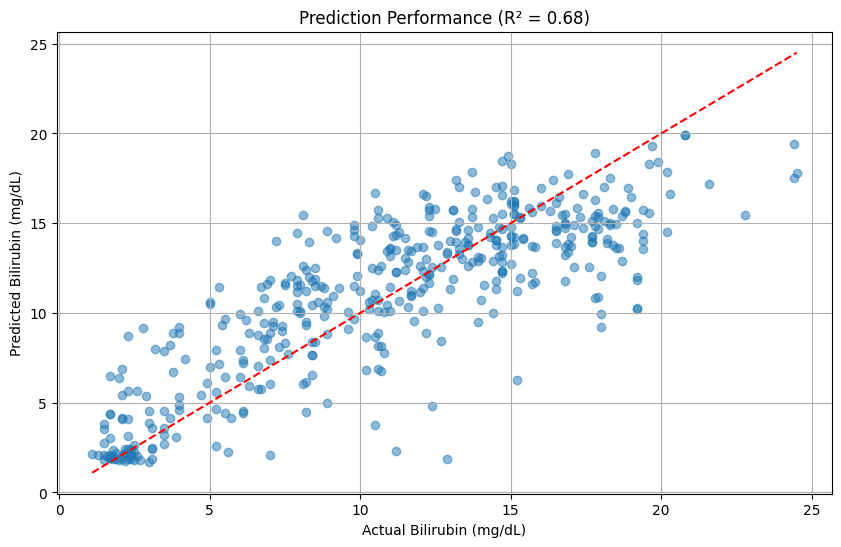

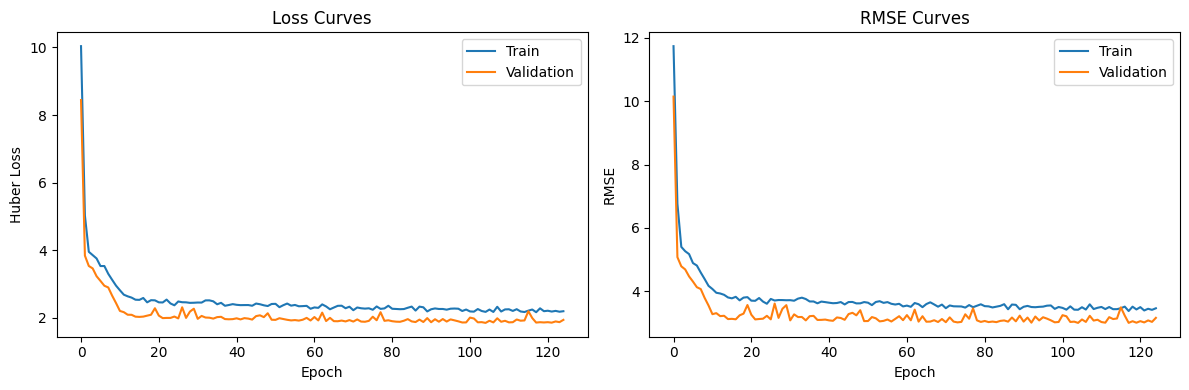

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.show()

# --- Plot Training History ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'], label='Train')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation')
plt.title('RMSE Curves')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
model.evaluate({'rgb_input': rgb_test, 'hsv_input': hsv_test}, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 1.9044 - mae: 2.3490 - root_mean_squared_error: 3.0415


[1.9043817520141602, 2.3489573001861572, 3.041510581970215]